## Nama: Rendi Salim
## Email: rendisalim10@gmail.com


In [13]:
!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rendisalim","key":"55568953d6444ba3a11f024b00fb8394"}'}

In [3]:
%cd //

/


In [8]:
!pwd

/


In [14]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json 

kaggle.json


In [16]:
!mkdir NLP_project

In [18]:
!kaggle datasets download -d mrutyunjaybiswal/iitjee-neet-aims-students-questions-data -p /NLP_project

 52% 5.00M/9.60M [00:00<00:00, 30.1MB/s]
100% 9.60M/9.60M [00:00<00:00, 46.8MB/s]


In [19]:
#Extract data 
import zipfile, os
localZip = '/NLP_project/iitjee-neet-aims-students-questions-data.zip'
zipRef = zipfile.ZipFile(localZip, 'r')
zipRef.extractall('/NLP_project')
zipRef.close()

In [22]:
%cd /NLP_project/

/NLP_project


In [40]:
import pandas as pd
df = pd.read_csv('subjects-questions.csv')
df.head()

,eng,Subject
0,An anti-forest measure is\nA. Afforestation\nB...,Biology
1,"Among the following organic acids, the acid pr...",Chemistry
2,If the area of two similar triangles are equal...,Maths
3,"In recent year, there has been a growing\nconc...",Biology
4,Which of the following statement\nregarding tr...,Physics


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122519 entries, 0 to 122518
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   eng      122519 non-null  object
 1   Subject  122519 non-null  object
dtypes: object(2)
memory usage: 1.9+ MB


In [42]:
df.rename(columns={'eng':'Question'}, inplace = True)

In [43]:
len(df[df.duplicated()])

811

In [44]:
df.drop_duplicates(inplace=True)

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121708 entries, 0 to 122518
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Question  121708 non-null  object
 1   Subject   121708 non-null  object
dtypes: object(2)
memory usage: 2.8+ MB


In [63]:
df['Question']

0         An anti-forest measure is\nA. Afforestation\nB...
1         Among the following organic acids, the acid pr...
2         If the area of two similar triangles are equal...
3         In recent year, there has been a growing\nconc...
4         Which of the following statement\nregarding tr...
                                ...                        
122514    Which of the following group of\ncharacters is...
122515    Light year is the\nA. light emitted by the sun...
122516    Member of Dipnoi are native of\nA. India.\nB. ...
122517    In one average-life,\nA. half the active nucle...
122518    State whether true or false.\nA magnetic field...
Name: Question, Length: 121708, dtype: object

In [45]:
df['Subject'].value_counts()

Physics      38128
Chemistry    37612
Maths        32874
Biology      13094
Name: Subject, dtype: int64

In [49]:
#mengambil 10000 data untuk setiap kelas
dfPhysics = df[df['Subject'] == 'Physics'].sample(n=10000, random_state=1)
dfChem = df[df['Subject'] == 'Chemistry'].sample(n=10000, random_state=1)
dfMath = df[df['Subject'] == 'Maths'].sample(n=10000, random_state=1)
dfBio = df[df['Subject'] == 'Biology'].sample(n=10000, random_state=1)

In [57]:
frames = [dfPhysics, dfChem, dfMath, dfBio]
dfClean = pd.concat(frames,
                  ignore_index = True)

In [59]:
#one-hot-encoding
subject = pd.get_dummies(dfClean['Subject'])
dfBaru = pd.concat([dfClean, subject], axis=1)
dfBaru.drop(columns='Subject', inplace=True)
dfBaru.head()

,Question,Biology,Chemistry,Maths,Physics
0,Pulling of a cart/tram is an example of\nA . R...,0,0,0,1
1,The maximum number of possible interference ma...,0,0,0,1
2,The emergent ray in a prism bends the normal.\...,0,0,0,1
3,Force applied by a lady is \( 2 \mathrm{N} \) ...,0,0,0,1
4,A water tank is filled with water upto\nheight...,0,0,0,1


In [61]:
#ubah data menjadi numpy array
question = dfBaru['Question'].values
label = dfBaru[['Biology', 'Chemistry', 'Maths', 'Physics']].values


In [64]:
from sklearn.model_selection import train_test_split
questionTrain, questionTest, labelTrain, labelTest = train_test_split(question, label, test_size=0.2)

In [98]:
print('Total sample = ', len(dfBaru))
print('Total data train = ', len(questionTrain))
print('Total data validation = ', len(questionTest))

Total sample =  40000
Total data train =  32000
Total data validation =  8000


In [65]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=50000, oov_token ='x')
tokenizer.fit_on_texts(questionTrain)
tokenizer.fit_on_texts(questionTest)

sequenceTrain = tokenizer.texts_to_sequences(questionTrain)
sequenceTest = tokenizer.texts_to_sequences(questionTest)

paddedTrain = pad_sequences(sequenceTrain)
paddedTest = pad_sequences(sequenceTest)

In [75]:
class Callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.91 and logs.get('val_accuracy') > 0.91):
      self.model.stop_training = True

callbacks = Callback()

In [88]:
#Model Evaluation plot
import matplotlib.pyplot as plt

def evalPlot(training):
  plt.style.use('seaborn')
  plt.figure(figsize = (8,6))

  plt.subplot(1,2,1)
  trainAcc = training.history['accuracy']
  valAcc = training.history['val_accuracy']
  epoch = range(len(trainAcc))
  trainAccPlot = plt.plot(epoch, trainAcc, 'r')
  valAccPlot = plt.plot(epoch, valAcc, 'b')
  plt.title('Akurasi training vs Akurasi Validasi')
  plt.legend(['Train Accuracy', 'Validation Accuracy'], loc=0)

  plt.subplot(1,2,2)
  trainLoss = training.history['loss']
  valLoss = training.history['val_loss']
  trainLossPlt = plt.plot(epoch, trainLoss, 'r')
  valLossPlt = plt.plot(epoch, valLoss, 'b')
  plt.title('Loss Training vs Loss Validasi')
  plt.legend(['Train Loss', 'Validation Loss'], loc=0)

In [91]:
import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=50000, output_dim=16),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(256, activation = 'sigmoid'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation = 'sigmoid'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation = 'softmax')
])

In [92]:
model.compile(loss='categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

Epoch 1/50
320/320 - 16s - loss: 1.3456 - accuracy: 0.3159 - val_loss: 1.0608 - val_accuracy: 0.5173
Epoch 2/50
320/320 - 15s - loss: 0.8143 - accuracy: 0.6536 - val_loss: 0.5927 - val_accuracy: 0.7575
Epoch 3/50
320/320 - 15s - loss: 0.4869 - accuracy: 0.8260 - val_loss: 0.4273 - val_accuracy: 0.8575
Epoch 4/50
320/320 - 15s - loss: 0.3149 - accuracy: 0.9062 - val_loss: 0.3464 - val_accuracy: 0.8916
Epoch 5/50
320/320 - 15s - loss: 0.2618 - accuracy: 0.9240 - val_loss: 0.3551 - val_accuracy: 0.8884
Epoch 6/50
320/320 - 15s - loss: 0.1965 - accuracy: 0.9463 - val_loss: 0.3118 - val_accuracy: 0.9094
Epoch 7/50
320/320 - 15s - loss: 0.1658 - accuracy: 0.9570 - val_loss: 0.2935 - val_accuracy: 0.9100


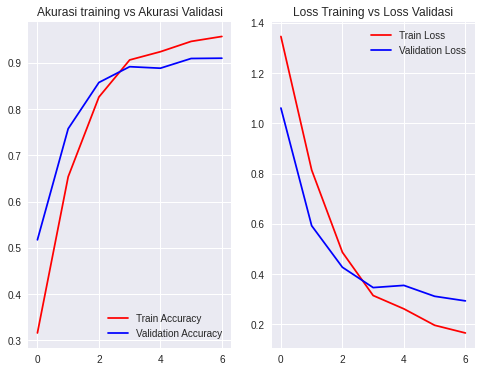

In [93]:
history = model.fit(paddedTrain, labelTrain, 
              epochs=50,
              validation_data = (paddedTest, labelTest),
              verbose = 2,
              batch_size = 100,
              callbacks=[callbacks])

evalPlot(history)

In [100]:
import numpy as np
newQuestion = ['Why is tartaric acid added into baking soda to get baking powder?']
seq = tokenizer.texts_to_sequences(newQuestion)
padded = pad_sequences(seq)
pred = model.predict(padded)
label = ['Biology', 'Chemistry', 'Maths', 'Physics']
print(pred, label[np.argmax(pred)])

[[2.2716101e-03 9.8678201e-01 1.3814647e-04 1.0808278e-02]] Chemistry
